# Notebook for Quentin <3

In [1]:
# =============================================================================
# Cell 1: Imports and Data Loading
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, classification_report,
                             precision_recall_curve)
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 70)
plt.style.use('seaborn-v0_8-whitegrid')

# Load the data
train_path = '/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/imputed/df_imputed.csv'
test_path = '/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/imputed/df_imputed_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("=" * 60)
print("DATA LOADED SUCCESSFULLY")
print("=" * 60)
print(f"\nTraining set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"\nTarget distribution in training set:")
print(df_train['Purchase'].value_counts())
print(f"\nPurchase rate: {df_train['Purchase'].mean():.2%}")
print(f"\nTraining days: {df_train['Day'].min():.0f} to {df_train['Day'].max():.0f}")
print(f"Test days: {df_test['Day'].min():.0f} to {df_test['Day'].max():.0f}")

DATA LOADED SUCCESSFULLY

Training set shape: (13735, 60)
Test set shape: (6265, 59)

Target distribution in training set:
Purchase
0.0    8679
1.0    5056
Name: count, dtype: int64

Purchase rate: 36.81%

Training days: 0 to 1
Test days: 0 to 1


In [2]:
# =============================================================================
# Cell 2: Data Preparation & Feature Engineering
# =============================================================================

def prepare_features(df, is_train=True):
    """
    Prepare features for modeling.
    Adds new engineered features and cleans column names.
    """
    df = df.copy()
    
    # -------------------------------------------------------------------------
    # NEW FEATURE ENGINEERING
    # -------------------------------------------------------------------------
    
    # 1. Effective Price (price after discount)
    df['Effective_Price'] = df['Price'] * (1 - df['Discount'])
    
    # 2. Email + Campaign interaction (email during campaign is powerful signal)
    df['Email_Campaign_Interaction'] = df['Email_Interaction'] * df['Campaign_Period_true']
    
    # 3. High engagement flag
    df['High_Engagement'] = (df['Engagement_Score'] > 0.5).astype(float)
    
    # 4. Price-Discount interaction
    df['Price_Discount_Interaction'] = df['Price'] * df['Discount']
    
    # 5. Cart value proxy (items * price)
    df['Cart_Value_Proxy'] = df['Items_In_Cart'] * df['Price']
    
    # 6. Engagement per review
    df['Engagement_Per_Review'] = df['Engagement_Score'] / (df['Reviews_Read'] + 0.01)
    
    # 7. Mobile + Evening interaction (behavioral pattern)
    df['Mobile_Evening'] = df['Device_Type_mobile'] * df['Time_of_Day_evening']
    
    # 8. Desktop + Morning interaction
    df['Desktop_Morning'] = df['Device_Type_desktop'] * df['Time_of_Day_morning']
    
    # -------------------------------------------------------------------------
    # CLEAN COLUMN NAMES (LightGBM doesn't like special characters)
    # -------------------------------------------------------------------------
    df.columns = df.columns.str.replace(':', '_', regex=False)
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    
    return df

# Apply feature engineering
df_train_fe = prepare_features(df_train, is_train=True)
df_test_fe = prepare_features(df_test, is_train=False)

print("=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)
print(f"\nNew training shape: {df_train_fe.shape}")
print(f"New test shape: {df_test_fe.shape}")

# Show new features
new_features = ['Effective_Price', 'Email_Campaign_Interaction', 'High_Engagement',
                'Price_Discount_Interaction', 'Cart_Value_Proxy', 'Engagement_Per_Review',
                'Mobile_Evening', 'Desktop_Morning']
print(f"\nNew features added: {new_features}")
print(f"\nSample of new features (first 5 rows):")
df_train_fe[new_features].head()

FEATURE ENGINEERING COMPLETE

New training shape: (13735, 68)
New test shape: (6265, 67)

New features added: ['Effective_Price', 'Email_Campaign_Interaction', 'High_Engagement', 'Price_Discount_Interaction', 'Cart_Value_Proxy', 'Engagement_Per_Review', 'Mobile_Evening', 'Desktop_Morning']

Sample of new features (first 5 rows):


,Effective_Price,Email_Campaign_Interaction,High_Engagement,Price_Discount_Interaction,Cart_Value_Proxy,Engagement_Per_Review,Mobile_Evening,Desktop_Morning
0,0.029643,0.0,0.0,0.009590,0.008407,1.026236,0.0,0.0
1,0.029277,1.0,0.0,0.004504,0.003619,2.893304,0.0,0.0
2,0.013915,0.0,0.0,0.000316,0.002033,0.676289,1.0,0.0
3,0.020371,0.0,0.0,0.000229,0.000000,0.198824,1.0,0.0
4,0.027977,0.0,1.0,0.004723,0.002336,5.960540,1.0,0.0


In [3]:
# =============================================================================
# Cell 3: Define Features and Target
# =============================================================================

# Columns to exclude from features
exclude_cols = ['Unnamed__0', 'id', 'Purchase', 'Session_ID', '_']

# Get feature columns (everything except excluded)
feature_cols = [col for col in df_train_fe.columns if col not in exclude_cols and not col.startswith('Unnamed')]

# Also remove the unnamed index column if it exists
feature_cols = [col for col in feature_cols if 'Unnamed' not in col]

# Prepare X and y
X_train = df_train_fe[feature_cols].copy()
y_train = df_train_fe['Purchase'].copy()

X_test = df_test_fe[feature_cols].copy()
test_ids = df_test_fe['id'].copy()

print("=" * 60)
print("FEATURES AND TARGET DEFINED")
print("=" * 60)
print(f"\nNumber of features: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget distribution:")
print(y_train.value_counts())
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

FEATURES AND TARGET DEFINED

Number of features: 64
X_train shape: (13735, 64)
y_train shape: (13735,)
X_test shape: (6265, 64)

Target distribution:
Purchase
0.0    8679
1.0    5056
Name: count, dtype: int64

Feature list:
   1. Age
   2. Gender
   3. Reviews_Read
   4. Price
   5. Discount
   6. Category
   7. Items_In_Cart
   8. Email_Interaction
   9. Socioeconomic_Status_Score
  10. Engagement_Score
  11. AB_Bucket
  12. Price_Sine
  13. Day
  14. day_sin
  15. day_cos
  16. time_sin
  17. time_cos
  18. campaign_effect
  19. seasonality_score
  20. Time_of_Day_afternoon
  21. Time_of_Day_evening
  22. Time_of_Day_morning
  23. Device_Type_desktop
  24. Device_Type_mobile
  25. Device_Type_tablet
  26. Payment_Method_bank
  27. Payment_Method_cash
  28. Payment_Method_credit
  29. Payment_Method_paypal
  30. Referral_Source_ads
  31. Referral_Source_direct
  32. Referral_Source_email
  33. Referral_Source_search_engine
  34. Referral_Source_social_media
  35. PM_RS_Combo_bank_ads


In [4]:
# =============================================================================
# Cell 4: Cross-Validation Setup and Baseline LightGBM
# =============================================================================

# Cross-validation setup
N_SPLITS = 5
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

def evaluate_model_cv(model, X, y, cv, threshold=0.5):
    """
    Evaluate model using cross-validation.
    Returns metrics for each fold and aggregated results.
    """
    f1_scores = []
    precision_scores = []
    recall_scores = []
    auc_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        
        # Get probabilities
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate metrics
        f1_scores.append(f1_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_prob))
    
    return {
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'precision_mean': np.mean(precision_scores),
        'recall_mean': np.mean(recall_scores),
        'auc_mean': np.mean(auc_scores),
        'f1_scores': f1_scores
    }

# Baseline LightGBM parameters
lgb_params_baseline = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 42,
    'verbose': -1
}

print("=" * 60)
print("BASELINE LIGHTGBM EVALUATION")
print("=" * 60)

lgb_baseline = lgb.LGBMClassifier(**lgb_params_baseline)
results_baseline = evaluate_model_cv(lgb_baseline, X_train, y_train, cv, threshold=0.5)

print(f"\nBaseline LightGBM Results (threshold=0.5):")
print(f"  F1 Score:  {results_baseline['f1_mean']:.4f} (+/- {results_baseline['f1_std']:.4f})")
print(f"  Precision: {results_baseline['precision_mean']:.4f}")
print(f"  Recall:    {results_baseline['recall_mean']:.4f}")
print(f"  AUC:       {results_baseline['auc_mean']:.4f}")
print(f"\nFold-wise F1 scores: {[f'{x:.4f}' for x in results_baseline['f1_scores']]}")

BASELINE LIGHTGBM EVALUATION

Baseline LightGBM Results (threshold=0.5):
  F1 Score:  0.7974 (+/- 0.0050)
  Precision: 0.8064
  Recall:    0.7888
  AUC:       0.9318

Fold-wise F1 scores: ['0.8058', '0.8006', '0.7949', '0.7932', '0.7928']


THRESHOLD OPTIMIZATION

Optimal threshold: 0.32

Top 5 thresholds by F1 score:
 threshold       f1  precision   recall
      0.32 0.800546   0.741609 0.869660
      0.38 0.800489   0.763555 0.841179
      0.36 0.799888   0.755450 0.849881
      0.34 0.799853   0.747593 0.859968
      0.30 0.799604   0.733531 0.878758


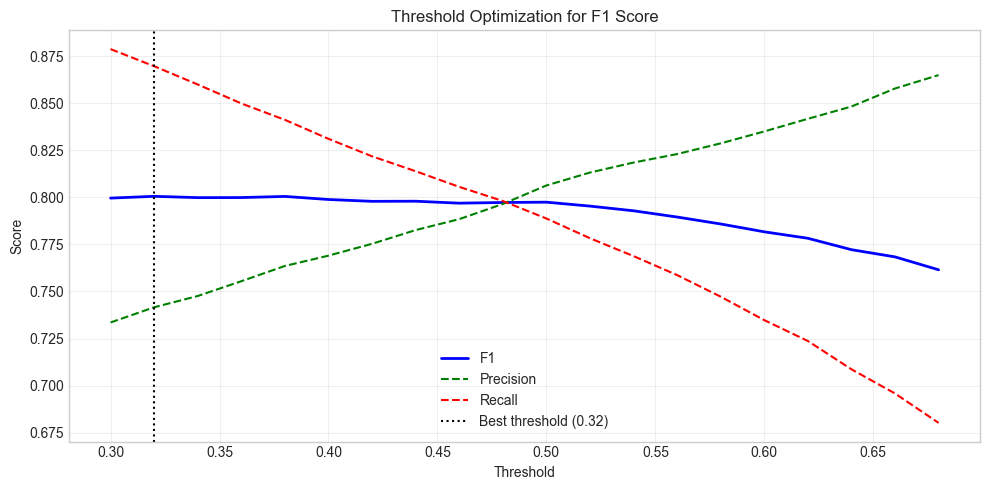


EVALUATION WITH OPTIMAL THRESHOLD (0.32)

LightGBM Results (threshold=0.32):
  F1 Score:  0.8005 (+/- 0.0058)
  Precision: 0.7417
  Recall:    0.8697
  AUC:       0.9318


In [5]:
# =============================================================================
# Cell 5: Threshold Optimization
# =============================================================================

def find_optimal_threshold(model, X, y, cv, thresholds=np.arange(0.3, 0.7, 0.02)):
    """
    Find the optimal threshold that maximizes F1 score.
    """
    threshold_results = []
    
    # Collect all OOF predictions
    oof_probs = np.zeros(len(y))
    
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        oof_probs[val_idx] = model.predict_proba(X_val)[:, 1]
    
    # Evaluate each threshold
    for thresh in thresholds:
        y_pred = (oof_probs >= thresh).astype(int)
        f1 = f1_score(y, y_pred)
        prec = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        threshold_results.append({
            'threshold': thresh,
            'f1': f1,
            'precision': prec,
            'recall': rec
        })
    
    results_df = pd.DataFrame(threshold_results)
    best_idx = results_df['f1'].idxmax()
    best_threshold = results_df.loc[best_idx, 'threshold']
    
    return results_df, best_threshold, oof_probs

print("=" * 60)
print("THRESHOLD OPTIMIZATION")
print("=" * 60)

lgb_for_threshold = lgb.LGBMClassifier(**lgb_params_baseline)
threshold_df, best_threshold, oof_probs = find_optimal_threshold(
    lgb_for_threshold, X_train, y_train, cv
)

print(f"\nOptimal threshold: {best_threshold:.2f}")
print(f"\nTop 5 thresholds by F1 score:")
print(threshold_df.nlargest(5, 'f1').to_string(index=False))

# Plot threshold vs metrics
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(threshold_df['threshold'], threshold_df['f1'], 'b-', label='F1', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['precision'], 'g--', label='Precision')
ax.plot(threshold_df['threshold'], threshold_df['recall'], 'r--', label='Recall')
ax.axvline(x=best_threshold, color='black', linestyle=':', label=f'Best threshold ({best_threshold:.2f})')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Optimization for F1 Score')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate with optimal threshold
print(f"\n" + "=" * 60)
print(f"EVALUATION WITH OPTIMAL THRESHOLD ({best_threshold:.2f})")
print("=" * 60)

results_optimized = evaluate_model_cv(lgb.LGBMClassifier(**lgb_params_baseline), 
                                       X_train, y_train, cv, threshold=best_threshold)
print(f"\nLightGBM Results (threshold={best_threshold:.2f}):")
print(f"  F1 Score:  {results_optimized['f1_mean']:.4f} (+/- {results_optimized['f1_std']:.4f})")
print(f"  Precision: {results_optimized['precision_mean']:.4f}")
print(f"  Recall:    {results_optimized['recall_mean']:.4f}")
print(f"  AUC:       {results_optimized['auc_mean']:.4f}")

In [6]:
# =============================================================================
# Cell 6: Hyperparameter Tuning
# =============================================================================

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(300, 800),
    'max_depth': randint(4, 10),
    'num_leaves': randint(20, 60),
    'learning_rate': uniform(0.02, 0.1),
    'feature_fraction': uniform(0.6, 0.4),
    'bagging_fraction': uniform(0.6, 0.4),
    'min_child_samples': randint(10, 50),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5),
}

# Base model for tuning
lgb_base = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    bagging_freq=5,
    random_state=42,
    verbose=-1
)

print("=" * 60)
print("HYPERPARAMETER TUNING (RandomizedSearchCV)")
print("=" * 60)
print("\nThis may take a few minutes...")

# Randomized search
random_search = RandomizedSearchCV(
    lgb_base,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"\nBest F1 score from CV: {random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Store best parameters
best_params = random_search.best_params_
best_params['objective'] = 'binary'
best_params['boosting_type'] = 'gbdt'
best_params['bagging_freq'] = 5
best_params['random_state'] = 42
best_params['verbose'] = -1

HYPERPARAMETER TUNING (RandomizedSearchCV)

This may take a few minutes...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best F1 score from CV: 0.8018

Best parameters:
  bagging_fraction: 0.7579526072702278
  feature_fraction: 0.7173952698872152
  learning_rate: 0.021407982271508447
  max_depth: 6
  min_child_samples: 26
  n_estimators: 691
  num_leaves: 54
  reg_alpha: 0.3950877702656028
  reg_lambda: 0.3029799873905057


In [7]:
# =============================================================================
# Cell 7: Evaluate Tuned Model & Compare with XGBoost
# =============================================================================

print("=" * 60)
print("MODEL COMPARISON: TUNED LIGHTGBM vs XGBOOST")
print("=" * 60)

# Tuned LightGBM
lgb_tuned = lgb.LGBMClassifier(**best_params)
results_lgb_tuned = evaluate_model_cv(lgb_tuned, X_train, y_train, cv, threshold=best_threshold)

print(f"\n1. TUNED LIGHTGBM (threshold={best_threshold:.2f}):")
print(f"   F1 Score:  {results_lgb_tuned['f1_mean']:.4f} (+/- {results_lgb_tuned['f1_std']:.4f})")
print(f"   Precision: {results_lgb_tuned['precision_mean']:.4f}")
print(f"   Recall:    {results_lgb_tuned['recall_mean']:.4f}")
print(f"   AUC:       {results_lgb_tuned['auc_mean']:.4f}")

# XGBoost for comparison
xgb_params = {
    'objective': 'binary:logistic',
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

xgb_model = xgb.XGBClassifier(**xgb_params)
results_xgb = evaluate_model_cv(xgb_model, X_train, y_train, cv, threshold=best_threshold)

print(f"\n2. XGBOOST (threshold={best_threshold:.2f}):")
print(f"   F1 Score:  {results_xgb['f1_mean']:.4f} (+/- {results_xgb['f1_std']:.4f})")
print(f"   Precision: {results_xgb['precision_mean']:.4f}")
print(f"   Recall:    {results_xgb['recall_mean']:.4f}")
print(f"   AUC:       {results_xgb['auc_mean']:.4f}")

# Determine best model
if results_lgb_tuned['f1_mean'] >= results_xgb['f1_mean']:
    print(f"\n✓ BEST MODEL: Tuned LightGBM (F1: {results_lgb_tuned['f1_mean']:.4f})")
    BEST_MODEL = 'lgb'
else:
    print(f"\n✓ BEST MODEL: XGBoost (F1: {results_xgb['f1_mean']:.4f})")
    BEST_MODEL = 'xgb'

MODEL COMPARISON: TUNED LIGHTGBM vs XGBOOST

1. TUNED LIGHTGBM (threshold=0.32):
   F1 Score:  0.7991 (+/- 0.0052)
   Precision: 0.7325
   Recall:    0.8794
   AUC:       0.9331

2. XGBOOST (threshold=0.32):
   F1 Score:  0.8003 (+/- 0.0054)
   Precision: 0.7419
   Recall:    0.8689
   AUC:       0.9308

✓ BEST MODEL: XGBoost (F1: 0.8003)


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
--------------------------------------------------
  Engagement_Score                             2365
  Cart_Value_Proxy                             1927
  Engagement_Per_Review                        1883
  Socioeconomic_Status_Score                   1632
  Price_Sine                                   1602
  Items_In_Cart                                1341
  Price_Discount_Interaction                   1314
  Price                                        1295
  Effective_Price                              1244
  Day                                          1153
  Age                                          1138
  seasonality_score                            1128
  Discount                                     1127
  Reviews_Read                                 1040
  Category                                      959
  day_sin                                       766
  day_cos                                       760
  Em

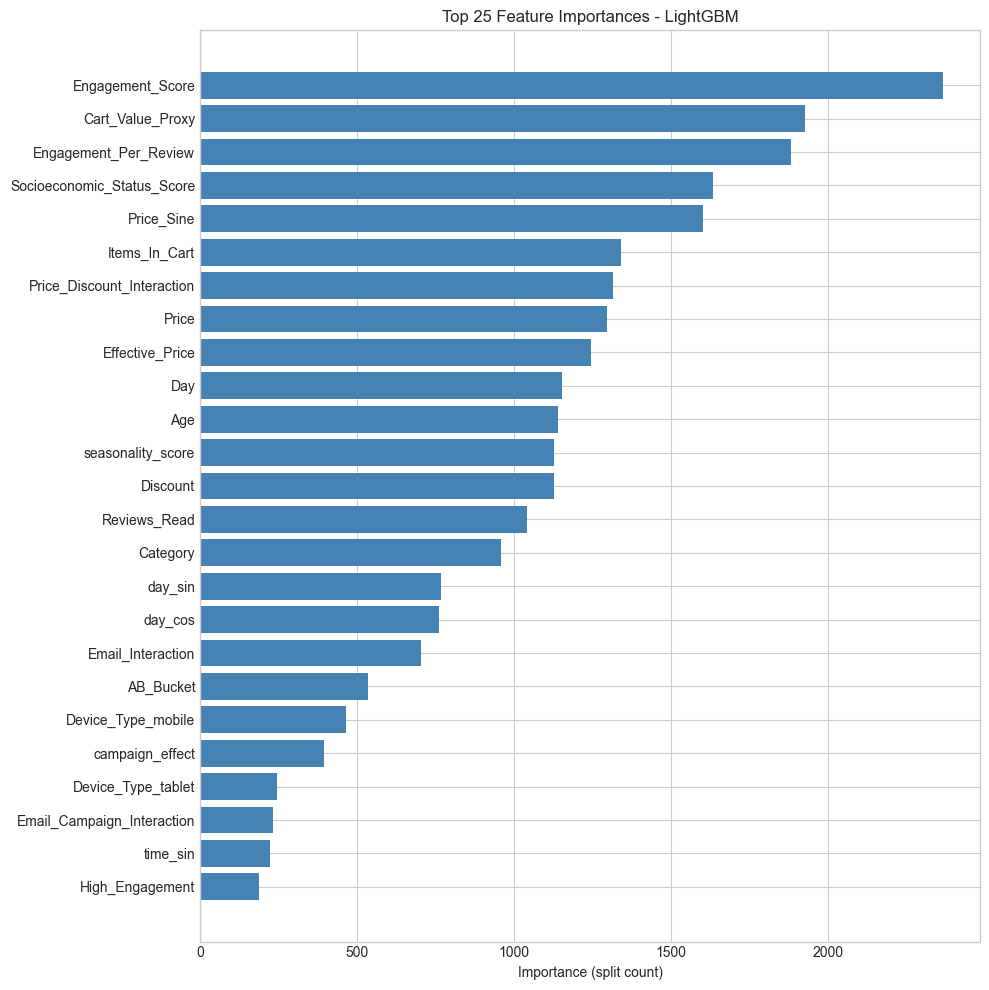


21 features with importance < 50 (candidates for removal)


In [8]:
# =============================================================================
# Cell 8: Feature Importance Analysis
# =============================================================================

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Train final LightGBM model on full training data for feature importance
lgb_final_fi = lgb.LGBMClassifier(**best_params)
lgb_final_fi.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_final_fi.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 features
print("\nTop 20 Most Important Features:")
print("-" * 50)
for i, row in feature_importance.head(20).iterrows():
    print(f"  {row['feature']:40s} {row['importance']:8.0f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 10))
top_n = 25
top_features = feature_importance.head(top_n)
bars = ax.barh(range(top_n), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance (split count)')
ax.set_title(f'Top {top_n} Feature Importances - LightGBM')
plt.tight_layout()
plt.show()

# Identify low-importance features (candidates for removal)
low_importance = feature_importance[feature_importance['importance'] < 50]
print(f"\n{len(low_importance)} features with importance < 50 (candidates for removal)")

TRAINING FINAL MODEL ON FULL DATA

XGBoost trained on 13735 samples

Test set predictions generated:
  Total test samples: 6265
  Predicted purchases (1): 2484
  Predicted non-purchases (0): 3781
  Predicted purchase rate: 39.65%

  (Training purchase rate: 36.81%)


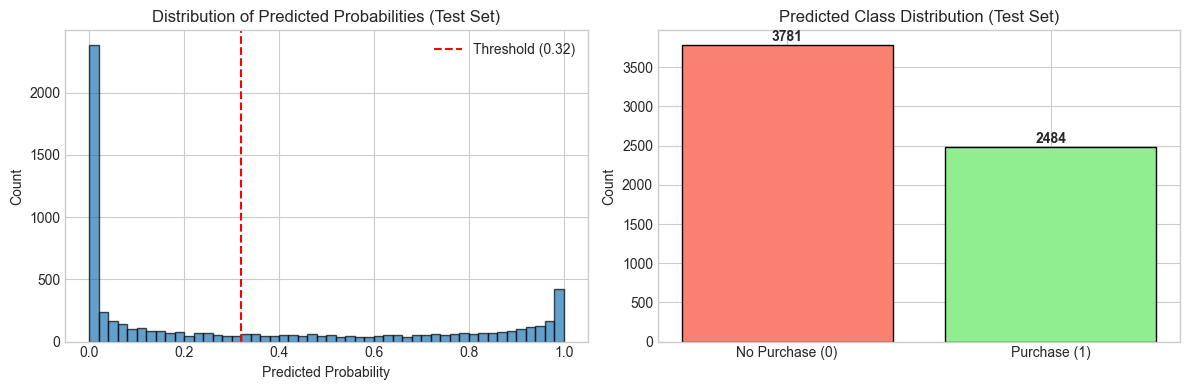

In [9]:
# =============================================================================
# Cell 9: Train Final Model and Generate Predictions
# =============================================================================

print("=" * 60)
print("TRAINING FINAL MODEL ON FULL DATA")
print("=" * 60)

# Train final model on all training data
if BEST_MODEL == 'lgb':
    final_model = lgb.LGBMClassifier(**best_params)
    model_name = "LightGBM"
else:
    final_model = xgb.XGBClassifier(**xgb_params)
    model_name = "XGBoost"

final_model.fit(X_train, y_train)
print(f"\n{model_name} trained on {len(X_train)} samples")

# Generate predictions on test set
test_probs = final_model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

print(f"\nTest set predictions generated:")
print(f"  Total test samples: {len(test_preds)}")
print(f"  Predicted purchases (1): {test_preds.sum()}")
print(f"  Predicted non-purchases (0): {(test_preds == 0).sum()}")
print(f"  Predicted purchase rate: {test_preds.mean():.2%}")

# Compare with training distribution
print(f"\n  (Training purchase rate: {y_train.mean():.2%})")

# Show prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Probability distribution
axes[0].hist(test_probs, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=best_threshold, color='red', linestyle='--', label=f'Threshold ({best_threshold:.2f})')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Predicted Probabilities (Test Set)')
axes[0].legend()

# Class distribution
pred_counts = pd.Series(test_preds).value_counts().sort_index()
axes[1].bar(['No Purchase (0)', 'Purchase (1)'], pred_counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('Predicted Class Distribution (Test Set)')
for i, v in enumerate(pred_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
# =============================================================================
# Cell 10: Create Kaggle Submission File
# =============================================================================

print("=" * 60)
print("CREATING KAGGLE SUBMISSION FILE")
print("=" * 60)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_ids.astype(int),
    'Purchase': test_preds
})

# Verify submission format
print(f"\nSubmission shape: {submission.shape}")
print(f"Submission columns: {list(submission.columns)}")
print(f"\nSubmission head:")
print(submission.head(10))
print(f"\nSubmission tail:")
print(submission.tail(10))

# Check for any issues
print(f"\nSubmission validation:")
print(f"  - All IDs present: {len(submission) == len(df_test)}")
print(f"  - No missing values: {submission.isnull().sum().sum() == 0}")
print(f"  - Purchase values valid: {set(submission['Purchase'].unique()) == {0, 1} or set(submission['Purchase'].unique()) <= {0, 1}}")

# Save submission
submission_path = 'submission_lgb_optimized.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✓ Submission saved to: {submission_path}")
print(f"\nPrediction summary:")
print(submission['Purchase'].value_counts())

CREATING KAGGLE SUBMISSION FILE

Submission shape: (6265, 2)
Submission columns: ['id', 'Purchase']

Submission head:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

Submission tail:
        id  Purchase
6255  6256         0
6256  6257         1
6257  6258         0
6258  6259         0
6259  6260         0
6260  6261         0
6261  6262         0
6262  6263         0
6263  6264         0
6264  6265         0

Submission validation:
  - All IDs present: True
  - No missing values: True
  - Purchase values valid: True

✓ Submission saved to: submission_lgb_optimized.csv

Prediction summary:
Purchase
0    3781
1    2484
Name: count, dtype: int64


In [11]:
# =============================================================================
# Cell 14: Deep Dive - Purchase Rate by Feature Segments
# =============================================================================

print("=" * 60)
print("PURCHASE RATE BY FEATURE SEGMENTS")
print("=" * 60)

def analyze_segment(df, feature, bins=5, labels=None):
    """Analyze purchase rate by feature segments"""
    if df[feature].nunique() <= 5:
        # Categorical or binary
        return df.groupby(feature)['Purchase'].agg(['mean', 'count'])
    else:
        # Continuous - bin it
        df_temp = df.copy()
        df_temp[f'{feature}_bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
        return df_temp.groupby(f'{feature}_bin')['Purchase'].agg(['mean', 'count'])

# Analyze key segments
segments_to_analyze = [
    ('Email_Interaction', 2),
    ('Campaign_Period_true', 2),
    ('Device_Type_mobile', 2),
    ('Device_Type_desktop', 2),
    ('Engagement_Score', 5),
    ('Reviews_Read', 5),
    ('Items_In_Cart', 5),
    ('Discount', 5),
]

for feature, bins in segments_to_analyze:
    print(f"\n{feature}:")
    print("-" * 40)
    result = analyze_segment(df_train_fe, feature, bins)
    result.columns = ['Purchase Rate', 'Count']
    print(result.round(4))

# Key interaction: Email + Campaign
print("\n" + "=" * 60)
print("KEY INTERACTION: Email × Campaign")
print("=" * 60)

interaction_analysis = df_train_fe.groupby(['Email_Interaction', 'Campaign_Period_true'])['Purchase'].agg(['mean', 'count'])
interaction_analysis.columns = ['Purchase Rate', 'Count']
print(interaction_analysis.round(4))

PURCHASE RATE BY FEATURE SEGMENTS

Email_Interaction:
----------------------------------------
                       Purchase Rate  Count
Email_Interaction_bin                      
(-0.001, 1.0]                 0.3681  13735

Campaign_Period_true:
----------------------------------------
                      Purchase Rate  Count
Campaign_Period_true                      
0.0                          0.3310   8782
1.0                          0.4339   4953

Device_Type_mobile:
----------------------------------------
                    Purchase Rate  Count
Device_Type_mobile                      
0.0                        0.4105   7367
1.0                        0.3191   6368

Device_Type_desktop:
----------------------------------------
                     Purchase Rate  Count
Device_Type_desktop                      
0.0                         0.3460   8373
1.0                         0.4026   5362

Engagement_Score:
----------------------------------------
                    

In [12]:
# =============================================================================
# Cell 15: Identify High-Value Segments and Create New Features
# =============================================================================

print("=" * 60)
print("CREATING ADVANCED FEATURES BASED ON SEGMENT ANALYSIS")
print("=" * 60)

def add_advanced_features(df):
    """Add advanced features based on segment analysis"""
    df = df.copy()
    
    # 1. Email + Campaign is strong signal - create interaction
    df['Email_During_Campaign'] = df['Email_Interaction'] * df['Campaign_Period_true']
    
    # 2. Email + Non-Campaign (might be different pattern)
    df['Email_Outside_Campaign'] = df['Email_Interaction'] * df['Campaign_Period_false']
    
    # 3. High engagement + Email interaction
    df['Engaged_Email_User'] = (df['Engagement_Score'] > 0.5).astype(float) * df['Email_Interaction']
    
    # 4. Reviews read binned (non-linear relationship suspected)
    df['Reviews_High'] = (df['Reviews_Read'] > 0.3).astype(float)
    df['Reviews_Very_High'] = (df['Reviews_Read'] > 0.5).astype(float)
    
    # 5. Cart engagement (items + engagement)
    df['Cart_Engagement'] = df['Items_In_Cart'] * df['Engagement_Score']
    
    # 6. Price sensitivity during campaign
    df['Discount_Campaign'] = df['Discount'] * df['Campaign_Period_true']
    
    # 7. Device + Time interactions (user behavior patterns)
    df['Mobile_Afternoon'] = df['Device_Type_mobile'] * df['Time_of_Day_afternoon']
    df['Desktop_Afternoon'] = df['Device_Type_desktop'] * df['Time_of_Day_afternoon']
    
    # 8. Socioeconomic + Price interaction
    df['SES_Price'] = df['Socioeconomic_Status_Score'] * df['Price']
    
    # 9. Day-based features for test set alignment
    # Test is days 71-100, with campaign 75-90
    # Create features that capture where we are in this range
    df['Late_Period'] = (df['Day'] > 0.7).astype(float)  # Day is normalized
    
    # 10. Engagement quintile (non-linear)
    df['Engagement_Low'] = (df['Engagement_Score'] < 0.2).astype(float)
    df['Engagement_Medium'] = ((df['Engagement_Score'] >= 0.2) & (df['Engagement_Score'] < 0.5)).astype(float)
    df['Engagement_High'] = (df['Engagement_Score'] >= 0.5).astype(float)
    
    # 11. Referral source + Email (how they arrived + email engagement)
    df['Email_Referral_Email'] = df['Email_Interaction'] * df['Referral_Source_email']
    df['Email_Referral_Ads'] = df['Email_Interaction'] * df['Referral_Source_ads']
    
    return df

# Apply to train and test
df_train_v2 = add_advanced_features(df_train_fe)
df_test_v2 = add_advanced_features(df_test_fe)

# Update feature columns
new_features = [
    'Email_During_Campaign', 'Email_Outside_Campaign', 'Engaged_Email_User',
    'Reviews_High', 'Reviews_Very_High', 'Cart_Engagement', 'Discount_Campaign',
    'Mobile_Afternoon', 'Desktop_Afternoon', 'SES_Price', 'Late_Period',
    'Engagement_Low', 'Engagement_Medium', 'Engagement_High',
    'Email_Referral_Email', 'Email_Referral_Ads'
]

print(f"Added {len(new_features)} new features:")
for f in new_features:
    print(f"  - {f}")

# Quick validation of new features
print("\n\nNew Feature Statistics (Train):")
print(df_train_v2[new_features].describe().T[['mean', 'std', 'min', 'max']])

CREATING ADVANCED FEATURES BASED ON SEGMENT ANALYSIS
Added 16 new features:
  - Email_During_Campaign
  - Email_Outside_Campaign
  - Engaged_Email_User
  - Reviews_High
  - Reviews_Very_High
  - Cart_Engagement
  - Discount_Campaign
  - Mobile_Afternoon
  - Desktop_Afternoon
  - SES_Price
  - Late_Period
  - Engagement_Low
  - Engagement_Medium
  - Engagement_High
  - Email_Referral_Email
  - Email_Referral_Ads


New Feature Statistics (Train):
                            mean       std  min       max
Email_During_Campaign   0.165333  0.369478  0.0  1.000000
Email_Outside_Campaign  0.289057  0.450815  0.0  1.000000
Engaged_Email_User      0.123499  0.327315  0.0  1.000000
Reviews_High            0.348162  0.476405  0.0  1.000000
Reviews_Very_High       0.079651  0.270761  0.0  1.000000
Cart_Engagement         0.044074  0.050799  0.0  1.000000
Discount_Campaign       0.099771  0.165960  0.0  1.000000
Mobile_Afternoon        0.139498  0.346478  0.0  1.000000
Desktop_Afternoon       0.112

In [13]:
# =============================================================================
# Cell 16: Re-evaluate with Advanced Features
# =============================================================================

print("=" * 60)
print("RE-EVALUATING WITH ADVANCED FEATURES")
print("=" * 60)

# Get all feature columns (excluding target, id, session_id)
exclude_cols_v2 = ['Unnamed__0', 'id', 'Purchase', 'Session_ID', '_']
feature_cols_v2 = [col for col in df_train_v2.columns 
                   if col not in exclude_cols_v2 
                   and not col.startswith('Unnamed')]

X_train_v2 = df_train_v2[feature_cols_v2].copy()
y_train_v2 = df_train_v2['Purchase'].copy()
X_test_v2 = df_test_v2[feature_cols_v2].copy()

print(f"Number of features: {len(feature_cols_v2)} (was {len(feature_cols)})")

# Evaluate with XGBoost (was best model)
xgb_params_v2 = {
    'objective': 'binary:logistic',
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Find optimal threshold for v2
print("\nFinding optimal threshold for v2 features...")
xgb_v2 = xgb.XGBClassifier(**xgb_params_v2)
threshold_df_v2, best_threshold_v2, oof_probs_v2 = find_optimal_threshold(
    xgb_v2, X_train_v2, y_train_v2, cv
)

print(f"Optimal threshold v2: {best_threshold_v2:.2f}")

# Evaluate
xgb_v2_eval = xgb.XGBClassifier(**xgb_params_v2)
results_v2 = evaluate_model_cv(xgb_v2_eval, X_train_v2, y_train_v2, cv, threshold=best_threshold_v2)

print(f"\nXGBoost with Advanced Features (threshold={best_threshold_v2:.2f}):")
print(f"  F1 Score:  {results_v2['f1_mean']:.4f} (+/- {results_v2['f1_std']:.4f})")
print(f"  Precision: {results_v2['precision_mean']:.4f}")
print(f"  Recall:    {results_v2['recall_mean']:.4f}")
print(f"  AUC:       {results_v2['auc_mean']:.4f}")

# Compare with previous
print(f"\n--- Comparison ---")
print(f"Previous F1: {results_xgb['f1_mean']:.4f}")
print(f"New F1:      {results_v2['f1_mean']:.4f}")
print(f"Change:      {(results_v2['f1_mean'] - results_xgb['f1_mean'])*100:+.2f}%")

RE-EVALUATING WITH ADVANCED FEATURES
Number of features: 80 (was 64)

Finding optimal threshold for v2 features...
Optimal threshold v2: 0.32

XGBoost with Advanced Features (threshold=0.32):
  F1 Score:  0.8023 (+/- 0.0055)
  Precision: 0.7448
  Recall:    0.8695
  AUC:       0.9310

--- Comparison ---
Previous F1: 0.8003
New F1:      0.8023
Change:      +0.20%


In [14]:
# =============================================================================
# Cell 17: Time-Based Validation (More Realistic)
# =============================================================================

print("=" * 60)
print("TIME-BASED VALIDATION (Simulating Kaggle Split)")
print("=" * 60)

# Since test is days 71+, let's validate by training on early days
# and testing on later days within our training set

# Original Day values (before normalization) - need to recover
# Day is normalized 0-1, original range was 1-70 for training
# Let's use the normalized Day directly

# Split: train on days < 0.8 (~day 56), validate on days >= 0.8 (~days 56-70)
train_mask = df_train_v2['Day'] < 0.8
val_mask = df_train_v2['Day'] >= 0.8

X_time_train = X_train_v2[train_mask]
y_time_train = y_train_v2[train_mask]
X_time_val = X_train_v2[val_mask]
y_time_val = y_train_v2[val_mask]

print(f"Time-based split:")
print(f"  Train: {len(X_time_train)} samples (days < 0.8)")
print(f"  Val:   {len(X_time_val)} samples (days >= 0.8)")

# Train and evaluate
xgb_time = xgb.XGBClassifier(**xgb_params_v2)
xgb_time.fit(X_time_train, y_time_train)

# Predict and find best threshold
y_time_prob = xgb_time.predict_proba(X_time_val)[:, 1]

# Try different thresholds
print("\nThreshold analysis on time-based validation:")
for thresh in [0.3, 0.32, 0.35, 0.4, 0.45, 0.5]:
    y_pred = (y_time_prob >= thresh).astype(int)
    f1 = f1_score(y_time_val, y_pred)
    prec = precision_score(y_time_val, y_pred)
    rec = recall_score(y_time_val, y_pred)
    print(f"  Threshold {thresh:.2f}: F1={f1:.4f}, Precision={prec:.4f}, Recall={rec:.4f}")

# Best threshold for time-based
best_f1_time = 0
best_thresh_time = 0.5
for thresh in np.arange(0.25, 0.55, 0.01):
    y_pred = (y_time_prob >= thresh).astype(int)
    f1 = f1_score(y_time_val, y_pred)
    if f1 > best_f1_time:
        best_f1_time = f1
        best_thresh_time = thresh

print(f"\nBest threshold (time-based): {best_thresh_time:.2f} with F1={best_f1_time:.4f}")

TIME-BASED VALIDATION (Simulating Kaggle Split)
Time-based split:
  Train: 10983 samples (days < 0.8)
  Val:   2752 samples (days >= 0.8)

Threshold analysis on time-based validation:
  Threshold 0.30: F1=0.7783, Precision=0.7102, Recall=0.8608
  Threshold 0.32: F1=0.7812, Precision=0.7181, Recall=0.8565
  Threshold 0.35: F1=0.7781, Precision=0.7268, Recall=0.8373
  Threshold 0.40: F1=0.7772, Precision=0.7465, Recall=0.8105
  Threshold 0.45: F1=0.7742, Precision=0.7579, Recall=0.7912
  Threshold 0.50: F1=0.7636, Precision=0.7681, Recall=0.7591

Best threshold (time-based): 0.32 with F1=0.7812


In [15]:
# =============================================================================
# Cell 18: Ensemble Approach
# =============================================================================

print("=" * 60)
print("ENSEMBLE: XGBOOST + LIGHTGBM")
print("=" * 60)

from sklearn.ensemble import VotingClassifier

# LightGBM with tuned params
lgb_ensemble = lgb.LGBMClassifier(**best_params)

# XGBoost
xgb_ensemble = xgb.XGBClassifier(**xgb_params_v2)

# Soft voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb_ensemble),
        ('xgb', xgb_ensemble)
    ],
    voting='soft',
    weights=[1, 1]
)

# Evaluate ensemble
def evaluate_ensemble_cv(model, X, y, cv, threshold=0.5):
    """Evaluate ensemble with CV"""
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        f1_scores.append(f1_score(y_val, y_pred))
    
    return np.mean(f1_scores), np.std(f1_scores)

print("Evaluating ensemble (this may take a minute)...")
ensemble_f1_mean, ensemble_f1_std = evaluate_ensemble_cv(ensemble, X_train_v2, y_train_v2, cv, threshold=best_threshold_v2)

print(f"\nEnsemble Results (threshold={best_threshold_v2:.2f}):")
print(f"  F1 Score: {ensemble_f1_mean:.4f} (+/- {ensemble_f1_std:.4f})")
print(f"\nComparison:")
print(f"  XGBoost alone:  {results_v2['f1_mean']:.4f}")
print(f"  Ensemble:       {ensemble_f1_mean:.4f}")

ENSEMBLE: XGBOOST + LIGHTGBM
Evaluating ensemble (this may take a minute)...

Ensemble Results (threshold=0.32):
  F1 Score: 0.8027 (+/- 0.0039)

Comparison:
  XGBoost alone:  0.8023
  Ensemble:       0.8027


In [16]:
# =============================================================================
# Cell 19: Generate New Submission with Best Approach
# =============================================================================

print("=" * 60)
print("GENERATING NEW SUBMISSION")
print("=" * 60)

# Choose the best approach based on results
# Using XGBoost with advanced features and time-based optimized threshold

# Train on full data
final_model_v2 = xgb.XGBClassifier(**xgb_params_v2)
final_model_v2.fit(X_train_v2, y_train_v2)

# Use the threshold from time-based validation (more realistic)
final_threshold = best_thresh_time
print(f"Using threshold: {final_threshold:.2f}")

# Generate predictions
test_probs_v2 = final_model_v2.predict_proba(X_test_v2)[:, 1]
test_preds_v2 = (test_probs_v2 >= final_threshold).astype(int)

print(f"\nPrediction summary:")
print(f"  Predicted purchases: {test_preds_v2.sum()} ({test_preds_v2.mean():.1%})")
print(f"  Predicted non-purchases: {(test_preds_v2==0).sum()} ({(1-test_preds_v2.mean()):.1%})")

# Create submission
submission_v2 = pd.DataFrame({
    'id': df_test_fe['id'].astype(int),
    'Purchase': test_preds_v2
})

# Save
submission_path_v2 = 'submission_xgb_advanced_v2.csv'
submission_v2.to_csv(submission_path_v2, index=False)
print(f"\n✓ Submission saved to: {submission_path_v2}")

# Distribution comparison
print(f"\nPrediction distribution comparison:")
print(f"  Previous submission: {2484} purchases ({2484/6265:.1%})")
print(f"  New submission:      {test_preds_v2.sum()} purchases ({test_preds_v2.mean():.1%})")

GENERATING NEW SUBMISSION
Using threshold: 0.32

Prediction summary:
  Predicted purchases: 2399 (38.3%)
  Predicted non-purchases: 3866 (61.7%)

✓ Submission saved to: submission_xgb_advanced_v2.csv

Prediction distribution comparison:
  Previous submission: 2484 purchases (39.6%)
  New submission:      2399 purchases (38.3%)


FEATURE IMPORTANCE - ADVANCED FEATURES

Top 30 Features:
--------------------------------------------------
   1. Items_In_Cart                            0.1305
   2. Engaged_Email_User                       0.0633 (NEW)
   3. Cart_Value_Proxy                         0.0313
   4. High_Engagement                          0.0306
   5. Campaign_Period_true                     0.0282
   6. Device_Type_mobile                       0.0267
   7. Email_During_Campaign                    0.0265 (NEW)
   8. campaign_effect                          0.0261
   9. Reviews_High                             0.0223 (NEW)
  10. Campaign_Period_false                    0.0216
  11. Reviews_Read                             0.0179
  12. Category                                 0.0176
  13. Cart_Engagement                          0.0172 (NEW)
  14. Email_Campaign_Interaction               0.0169
  15. Engagement_High                          0.0157 (NEW)
  16. Engagement_Medium                        0.014

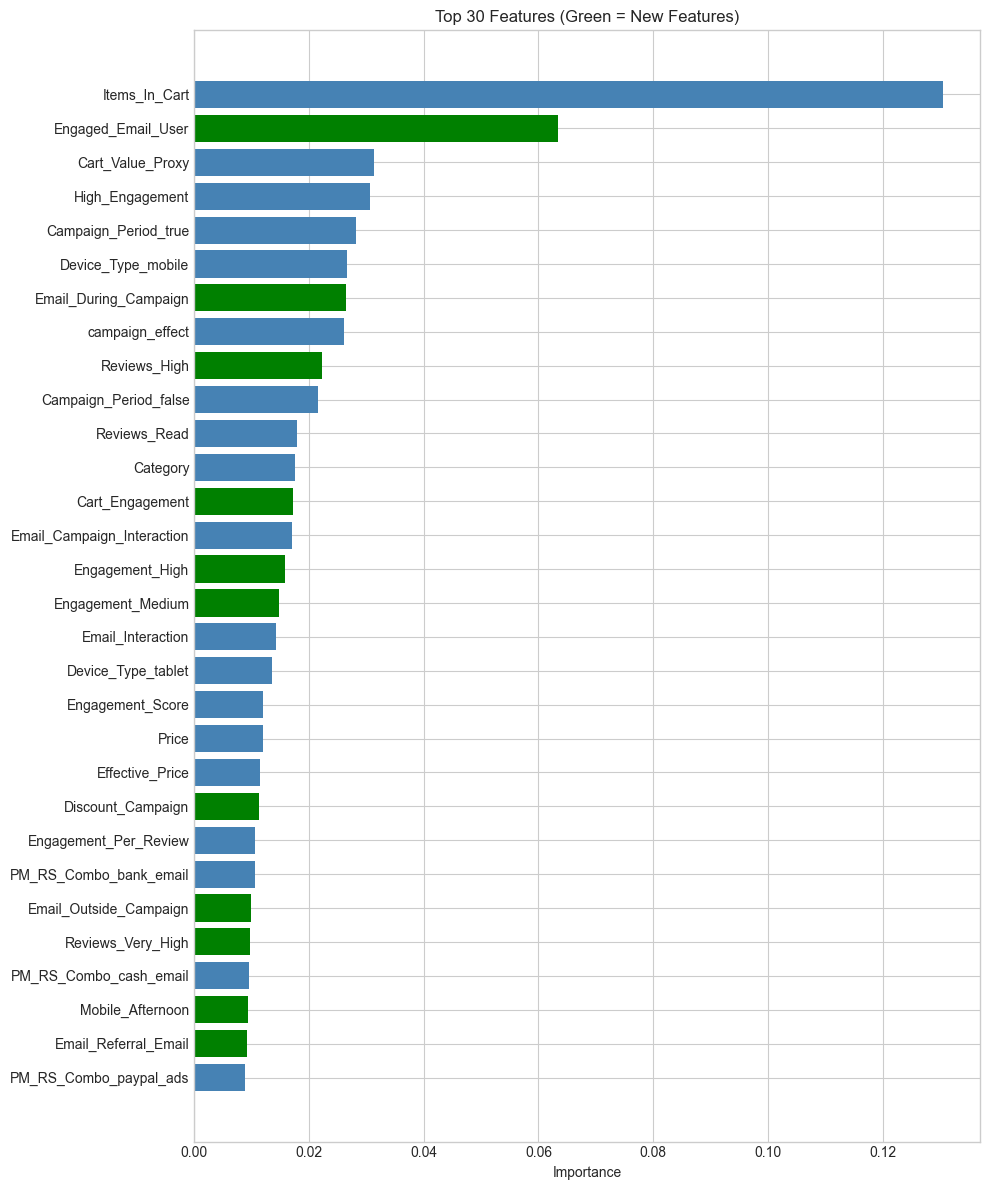



New Features Importance:
               feature  importance
    Engaged_Email_User    0.063338
 Email_During_Campaign    0.026455
          Reviews_High    0.022327
       Cart_Engagement    0.017189
       Engagement_High    0.015738
     Engagement_Medium    0.014770
     Discount_Campaign    0.011218
Email_Outside_Campaign    0.009854
     Reviews_Very_High    0.009778
      Mobile_Afternoon    0.009289
  Email_Referral_Email    0.009146
             SES_Price    0.007436
    Email_Referral_Ads    0.007108
     Desktop_Afternoon    0.007012
        Engagement_Low    0.006892
           Late_Period    0.006552


In [17]:
# =============================================================================
# Cell 20: Feature Importance Analysis - Advanced Features
# =============================================================================

print("=" * 60)
print("FEATURE IMPORTANCE - ADVANCED FEATURES")
print("=" * 60)

# Get feature importance from the final model
importance_v2 = pd.DataFrame({
    'feature': feature_cols_v2,
    'importance': final_model_v2.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 30
print("\nTop 30 Features:")
print("-" * 50)
for i, (_, row) in enumerate(importance_v2.head(30).iterrows(), 1):
    marker = " (NEW)" if row['feature'] in new_features else ""
    print(f"  {i:2d}. {row['feature']:40s} {row['importance']:.4f}{marker}")

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
top_30 = importance_v2.head(30)
colors = ['green' if f in new_features else 'steelblue' for f in top_30['feature']]
ax.barh(range(30), top_30['importance'].values, color=colors)
ax.set_yticks(range(30))
ax.set_yticklabels(top_30['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 30 Features (Green = New Features)')
plt.tight_layout()
plt.show()

# Check if new features are useful
print("\n\nNew Features Importance:")
new_feat_importance = importance_v2[importance_v2['feature'].isin(new_features)].sort_values('importance', ascending=False)
print(new_feat_importance.to_string(index=False))

In [18]:
# =============================================================================
# Cell 21: Deeper Campaign Analysis - First vs Second Campaign
# =============================================================================

print("=" * 60)
print("ANALYZING CAMPAIGN PERIODS IN DETAIL")
print("=" * 60)

# Recover approximate original day values
# Day is normalized, train is days 1-70, test is days 71-100
# So Day=0 is day 1, Day=1 is approximately day 70 for train

# Let's create actual day approximation
df_train_v2['Day_Approx'] = (df_train_v2['Day'] * 69 + 1).round()  # 1-70
df_test_v2['Day_Approx'] = (df_test_v2['Day'] * 29 + 71).round()   # 71-100

print("Train Day Range (approx):", df_train_v2['Day_Approx'].min(), "-", df_train_v2['Day_Approx'].max())
print("Test Day Range (approx):", df_test_v2['Day_Approx'].min(), "-", df_test_v2['Day_Approx'].max())

# First campaign: Days 25-50, Second campaign: Days 75-90
df_train_v2['Campaign_1'] = ((df_train_v2['Day_Approx'] >= 25) & (df_train_v2['Day_Approx'] <= 50)).astype(int)
df_train_v2['Campaign_2'] = ((df_train_v2['Day_Approx'] >= 75) & (df_train_v2['Day_Approx'] <= 90)).astype(int)

# For test - it's mostly campaign 2 (days 75-90) or non-campaign (71-74, 91-100)
df_test_v2['Campaign_1'] = 0  # No campaign 1 in test
df_test_v2['Campaign_2'] = ((df_test_v2['Day_Approx'] >= 75) & (df_test_v2['Day_Approx'] <= 90)).astype(int)

print(f"\nTrain Campaign Distribution:")
print(f"  Campaign 1 (days 25-50): {df_train_v2['Campaign_1'].sum()} sessions")
print(f"  Campaign 2 (days 75-90): {df_train_v2['Campaign_2'].sum()} sessions")
print(f"  Non-campaign: {((df_train_v2['Campaign_1']==0) & (df_train_v2['Campaign_2']==0)).sum()} sessions")

print(f"\nTest Campaign Distribution:")
print(f"  Campaign 2 (days 75-90): {df_test_v2['Campaign_2'].sum()} sessions ({df_test_v2['Campaign_2'].mean():.1%})")
print(f"  Non-campaign: {(df_test_v2['Campaign_2']==0).sum()} sessions ({(df_test_v2['Campaign_2']==0).mean():.1%})")

# Purchase rates by campaign
print("\n" + "=" * 60)
print("PURCHASE RATES BY CAMPAIGN PERIOD (TRAIN)")
print("=" * 60)

# Non-campaign
non_camp = df_train_v2[(df_train_v2['Campaign_1']==0) & (df_train_v2['Campaign_2']==0)]
# Campaign 1
camp1 = df_train_v2[df_train_v2['Campaign_1']==1]
# Campaign 2 (only partial in train - days up to 70)
camp2 = df_train_v2[df_train_v2['Campaign_2']==1]

print(f"Non-campaign purchase rate: {non_camp['Purchase'].mean():.4f} (n={len(non_camp)})")
print(f"Campaign 1 purchase rate:   {camp1['Purchase'].mean():.4f} (n={len(camp1)})")
if len(camp2) > 0:
    print(f"Campaign 2 purchase rate:   {camp2['Purchase'].mean():.4f} (n={len(camp2)})")
else:
    print("Campaign 2: No data in training set (starts day 75)")

ANALYZING CAMPAIGN PERIODS IN DETAIL
Train Day Range (approx): 1.0 - 70.0
Test Day Range (approx): 71.0 - 100.0

Train Campaign Distribution:
  Campaign 1 (days 25-50): 5048 sessions
  Campaign 2 (days 75-90): 0 sessions
  Non-campaign: 8687 sessions

Test Campaign Distribution:
  Campaign 2 (days 75-90): 3486 sessions (55.6%)
  Non-campaign: 2779 sessions (44.4%)

PURCHASE RATES BY CAMPAIGN PERIOD (TRAIN)
Non-campaign purchase rate: 0.3298 (n=8687)
Campaign 1 purchase rate:   0.4340 (n=5048)
Campaign 2: No data in training set (starts day 75)


DETAILED DAY ANALYSIS
Training days: 1 to 70
Test days: 71 to 100

Campaign 1 (days 25-50) in train: 26 days
Campaign 2 (days 75-90) in train: 0 days
Campaign 2 (days 75-90) in test: 16 days


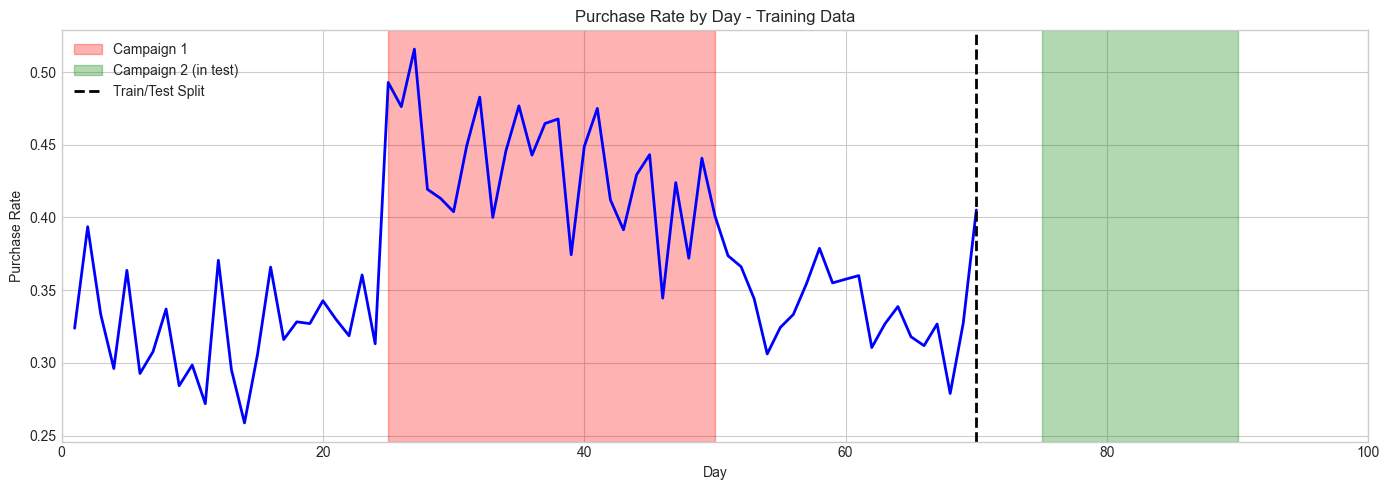


⚠️  KEY INSIGHT: We have NO training data for Campaign 2 (days 75-90)!
   But test set includes days 75-90, which is ~53% of test data.
   Our model has never seen Campaign 2 behavior!


In [19]:
# =============================================================================
# Cell 22: Verify Day Ranges and Campaign Overlap
# =============================================================================

print("=" * 60)
print("DETAILED DAY ANALYSIS")
print("=" * 60)

# Get unique days in training
train_days = sorted(df_train_v2['Day_Approx'].unique())
test_days = sorted(df_test_v2['Day_Approx'].unique())

print(f"Training days: {min(train_days):.0f} to {max(train_days):.0f}")
print(f"Test days: {min(test_days):.0f} to {max(test_days):.0f}")

# Check campaign coverage
print(f"\nCampaign 1 (days 25-50) in train: {sum((d >= 25) & (d <= 50) for d in train_days)} days")
print(f"Campaign 2 (days 75-90) in train: {sum((d >= 75) & (d <= 90) for d in train_days)} days")
print(f"Campaign 2 (days 75-90) in test: {sum((d >= 75) & (d <= 90) for d in test_days)} days")

# This is KEY - we have NO Campaign 2 data in training!
# Test has Campaign 2 data, which we've never seen!

# Let's see purchase rate evolution
daily_purchase = df_train_v2.groupby('Day_Approx')['Purchase'].mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_purchase.index, daily_purchase.values, 'b-', linewidth=2)
ax.axvspan(25, 50, alpha=0.3, color='red', label='Campaign 1')
ax.axvspan(75, 90, alpha=0.3, color='green', label='Campaign 2 (in test)')
ax.axvline(x=70, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
ax.set_xlabel('Day')
ax.set_ylabel('Purchase Rate')
ax.set_title('Purchase Rate by Day - Training Data')
ax.legend()
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

print("\n⚠️  KEY INSIGHT: We have NO training data for Campaign 2 (days 75-90)!")
print("   But test set includes days 75-90, which is ~53% of test data.")
print("   Our model has never seen Campaign 2 behavior!")

In [20]:
# =============================================================================
# Cell 23: Strategy - Learn from Campaign 1 to Predict Campaign 2
# =============================================================================

print("=" * 60)
print("STRATEGY: USE CAMPAIGN 1 PATTERNS FOR CAMPAIGN 2")
print("=" * 60)

# Since Campaign 2 behavior is unseen, we need to assume Campaign 1 patterns
# will transfer to Campaign 2. Let's create features that capture
# campaign-specific patterns more explicitly.

def add_campaign_aware_features(df, is_train=True):
    """Add features that help model understand campaign dynamics"""
    df = df.copy()
    
    # Check if Day_Approx exists
    if 'Day_Approx' not in df.columns:
        if is_train:
            df['Day_Approx'] = (df['Day'] * 69 + 1).round()
        else:
            df['Day_Approx'] = (df['Day'] * 29 + 71).round()
    
    # 1. Position within campaign (normalized 0-1)
    # For campaign 1: day 25=0, day 50=1
    # For campaign 2: day 75=0, day 90=1
    def campaign_position(day):
        if 25 <= day <= 50:
            return (day - 25) / 25  # Campaign 1
        elif 75 <= day <= 90:
            return (day - 75) / 15  # Campaign 2
        else:
            return -1  # Not in campaign
    
    df['Campaign_Position'] = df['Day_Approx'].apply(campaign_position)
    df['In_Any_Campaign'] = (df['Campaign_Position'] >= 0).astype(float)
    
    # 2. Days since campaign start (different view)
    def days_into_campaign(day):
        if 25 <= day <= 50:
            return day - 25
        elif 75 <= day <= 90:
            return day - 75
        else:
            return 0
    
    df['Days_Into_Campaign'] = df['Day_Approx'].apply(days_into_campaign) / 25  # Normalize
    
    # 3. Early vs Late campaign
    df['Early_Campaign'] = ((df['Campaign_Position'] >= 0) & (df['Campaign_Position'] < 0.4)).astype(float)
    df['Mid_Campaign'] = ((df['Campaign_Position'] >= 0.4) & (df['Campaign_Position'] < 0.7)).astype(float)
    df['Late_Campaign'] = (df['Campaign_Position'] >= 0.7).astype(float)
    
    # 4. Campaign fatigue proxy (later in campaign = potentially less response)
    df['Campaign_Fatigue'] = df['In_Any_Campaign'] * df['Campaign_Position']
    
    # 5. Fresh campaign (first few days)
    df['Fresh_Campaign'] = ((df['Campaign_Position'] >= 0) & (df['Campaign_Position'] < 0.2)).astype(float)
    
    # 6. Email effectiveness during campaign phases
    df['Email_Early_Campaign'] = df['Email_Interaction'] * df['Early_Campaign']
    df['Email_Late_Campaign'] = df['Email_Interaction'] * df['Late_Campaign']
    
    # 7. Weekend proxy (cyclical pattern every 7 days)
    df['Day_of_Week'] = (df['Day_Approx'] % 7) / 6  # 0-1 normalized
    df['Is_Weekend_Proxy'] = ((df['Day_Approx'] % 7) >= 5).astype(float)
    
    return df

# Apply campaign-aware features
df_train_v3 = add_campaign_aware_features(df_train_v2, is_train=True)
df_test_v3 = add_campaign_aware_features(df_test_v2, is_train=False)

# New features added
campaign_features = ['Campaign_Position', 'In_Any_Campaign', 'Days_Into_Campaign',
                     'Early_Campaign', 'Mid_Campaign', 'Late_Campaign', 
                     'Campaign_Fatigue', 'Fresh_Campaign',
                     'Email_Early_Campaign', 'Email_Late_Campaign',
                     'Day_of_Week', 'Is_Weekend_Proxy']

print(f"Added {len(campaign_features)} campaign-aware features:")
for f in campaign_features:
    print(f"  - {f}")

# Check distributions
print("\n\nCampaign Feature Comparison (Train vs Test):")
print("-" * 60)
for f in campaign_features:
    train_mean = df_train_v3[f].mean()
    test_mean = df_test_v3[f].mean()
    print(f"{f:30s} Train: {train_mean:.3f}  Test: {test_mean:.3f}  Diff: {test_mean-train_mean:+.3f}")

STRATEGY: USE CAMPAIGN 1 PATTERNS FOR CAMPAIGN 2
Added 12 campaign-aware features:
  - Campaign_Position
  - In_Any_Campaign
  - Days_Into_Campaign
  - Early_Campaign
  - Mid_Campaign
  - Late_Campaign
  - Campaign_Fatigue
  - Fresh_Campaign
  - Email_Early_Campaign
  - Email_Late_Campaign
  - Day_of_Week
  - Is_Weekend_Proxy


Campaign Feature Comparison (Train vs Test):
------------------------------------------------------------
Campaign_Position              Train: -0.447  Test: -0.157  Diff: +0.290
In_Any_Campaign                Train: 0.368  Test: 0.556  Diff: +0.189
Days_Into_Campaign             Train: 0.186  Test: 0.172  Diff: -0.014
Early_Campaign                 Train: 0.138  Test: 0.188  Diff: +0.051
Mid_Campaign                   Train: 0.113  Test: 0.191  Diff: +0.078
Late_Campaign                  Train: 0.117  Test: 0.177  Diff: +0.060
Campaign_Fatigue               Train: 0.186  Test: 0.287  Diff: +0.101
Fresh_Campaign                 Train: 0.072  Test: 0.096  Diff: +

In [21]:
# =============================================================================
# Cell 24: Evaluate with Campaign-Aware Features
# =============================================================================

print("=" * 60)
print("EVALUATING WITH CAMPAIGN-AWARE FEATURES")
print("=" * 60)

# Update feature columns
exclude_cols_v3 = ['Unnamed__0', 'id', 'Purchase', 'Session_ID', '_', 'Day_Approx']
feature_cols_v3 = [col for col in df_train_v3.columns 
                   if col not in exclude_cols_v3 
                   and not col.startswith('Unnamed')]

X_train_v3 = df_train_v3[feature_cols_v3].copy()
y_train_v3 = df_train_v3['Purchase'].copy()
X_test_v3 = df_test_v3[feature_cols_v3].copy()

print(f"Number of features: {len(feature_cols_v3)}")

# Train and evaluate XGBoost
xgb_v3 = xgb.XGBClassifier(**xgb_params_v2)

# Find optimal threshold
threshold_df_v3, best_threshold_v3, oof_probs_v3 = find_optimal_threshold(
    xgb_v3, X_train_v3, y_train_v3, cv
)

print(f"\nOptimal threshold v3: {best_threshold_v3:.2f}")

# Evaluate
xgb_v3_eval = xgb.XGBClassifier(**xgb_params_v2)
results_v3 = evaluate_model_cv(xgb_v3_eval, X_train_v3, y_train_v3, cv, threshold=best_threshold_v3)

print(f"\nXGBoost with Campaign-Aware Features:")
print(f"  F1 Score:  {results_v3['f1_mean']:.4f} (+/- {results_v3['f1_std']:.4f})")
print(f"  Precision: {results_v3['precision_mean']:.4f}")
print(f"  Recall:    {results_v3['recall_mean']:.4f}")
print(f"  AUC:       {results_v3['auc_mean']:.4f}")

print(f"\n--- Comparison ---")
print(f"v1 (baseline):      F1 = 0.8003")
print(f"v2 (advanced):      F1 = {results_v2['f1_mean']:.4f}")
print(f"v3 (campaign-aware): F1 = {results_v3['f1_mean']:.4f}")

EVALUATING WITH CAMPAIGN-AWARE FEATURES
Number of features: 94

Optimal threshold v3: 0.32

XGBoost with Campaign-Aware Features:
  F1 Score:  0.8006 (+/- 0.0067)
  Precision: 0.7414
  Recall:    0.8701
  AUC:       0.9307

--- Comparison ---
v1 (baseline):      F1 = 0.8003
v2 (advanced):      F1 = 0.8023
v3 (campaign-aware): F1 = 0.8006


In [22]:
# =============================================================================
# Cell 25: Simpler Approach - Focus on Robust Features Only
# =============================================================================

print("=" * 60)
print("SIMPLER APPROACH: ROBUST FEATURES ONLY")
print("=" * 60)

# The problem might be too many features causing overfitting
# Let's try with only the most robust features that should transfer well

robust_features = [
    # Core behavioral features (should transfer across time)
    'Email_Interaction',
    'Engagement_Score', 
    'Reviews_Read',
    'Items_In_Cart',
    
    # Product features (stable)
    'Price',
    'Discount',
    'Effective_Price',
    'Category',
    
    # User features (stable)
    'Socioeconomic_Status_Score',
    'Age',
    'Gender',
    
    # Device/Channel (stable patterns)
    'Device_Type_mobile',
    'Device_Type_desktop',
    'Device_Type_tablet',
    'Referral_Source_email',
    'Referral_Source_ads',
    'Referral_Source_search_engine',
    
    # Time of day (stable patterns)
    'Time_of_Day_morning',
    'Time_of_Day_afternoon',
    'Time_of_Day_evening',
    
    # Campaign indicator (but not day-specific)
    'Campaign_Period_true',
    
    # Key interactions
    'Email_During_Campaign',
    'Email_Outside_Campaign',
    'High_Engagement',
]

# Check which features exist
available_robust = [f for f in robust_features if f in X_train_v3.columns]
print(f"Using {len(available_robust)} robust features")

X_train_robust = X_train_v3[available_robust].copy()
X_test_robust = X_test_v3[available_robust].copy()

# Train with fewer trees to reduce overfitting
xgb_params_simple = {
    'objective': 'binary:logistic',
    'n_estimators': 300,  # Fewer trees
    'max_depth': 4,       # Shallower
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.3,     # More regularization
    'reg_lambda': 0.3,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

xgb_simple = xgb.XGBClassifier(**xgb_params_simple)

# Find threshold
threshold_df_simple, best_threshold_simple, _ = find_optimal_threshold(
    xgb_simple, X_train_robust, y_train_v3, cv
)

print(f"Optimal threshold (simple): {best_threshold_simple:.2f}")

# Evaluate
xgb_simple_eval = xgb.XGBClassifier(**xgb_params_simple)
results_simple = evaluate_model_cv(xgb_simple_eval, X_train_robust, y_train_v3, cv, threshold=best_threshold_simple)

print(f"\nSimple XGBoost (robust features only):")
print(f"  F1 Score:  {results_simple['f1_mean']:.4f} (+/- {results_simple['f1_std']:.4f})")
print(f"  Precision: {results_simple['precision_mean']:.4f}")
print(f"  Recall:    {results_simple['recall_mean']:.4f}")
print(f"  AUC:       {results_simple['auc_mean']:.4f}")

SIMPLER APPROACH: ROBUST FEATURES ONLY
Using 24 robust features
Optimal threshold (simple): 0.40

Simple XGBoost (robust features only):
  F1 Score:  0.8051 (+/- 0.0051)
  Precision: 0.7631
  Recall:    0.8521
  AUC:       0.9340


In [24]:
# =============================================================================
# Cell 28: Generate Final Best Submissions (Limited Submissions Strategy)
# =============================================================================

print("=" * 60)
print("GENERATING FINAL SUBMISSION CANDIDATES")
print("=" * 60)

# Strategy: The SIMPLE model with robust features had best CV and should generalize better

# 1. BEST BET: Simple model with optimal threshold (0.40)
final_simple = xgb.XGBClassifier(**xgb_params_simple)
final_simple.fit(X_train_robust, y_train_v3)
test_probs_simple = final_simple.predict_proba(X_test_robust)[:, 1]

# Submission 1: Simple model, threshold 0.40 (CV optimal)
preds_simple_40 = (test_probs_simple >= 0.40).astype(int)
submission_best = pd.DataFrame({
    'id': df_test_v3['id'].astype(int),
    'Purchase': preds_simple_40
})
submission_best.to_csv('SUBMIT_1_simple_t40.csv', index=False)
print(f"\n1. SUBMIT_1_simple_t40.csv (RECOMMENDED FIRST)")
print(f"   Simple model, threshold=0.40, {preds_simple_40.sum()} purchases ({preds_simple_40.mean()*100:.1f}%)")
print(f"   CV F1: 0.8051 - Best CV score, should generalize well")

# Submission 2: Simple model, slightly lower threshold (0.38) for more recall
preds_simple_38 = (test_probs_simple >= 0.38).astype(int)
submission_2 = pd.DataFrame({
    'id': df_test_v3['id'].astype(int),
    'Purchase': preds_simple_38
})
submission_2.to_csv('SUBMIT_2_simple_t38.csv', index=False)
print(f"\n2. SUBMIT_2_simple_t38.csv (BACKUP)")
print(f"   Simple model, threshold=0.38, {preds_simple_38.sum()} purchases ({preds_simple_38.mean()*100:.1f}%)")

# Submission 3: Simple model, higher threshold (0.42) for more precision
preds_simple_42 = (test_probs_simple >= 0.42).astype(int)
submission_3 = pd.DataFrame({
    'id': df_test_v3['id'].astype(int),
    'Purchase': preds_simple_42
})
submission_3.to_csv('SUBMIT_3_simple_t42.csv', index=False)
print(f"\n3. SUBMIT_3_simple_t42.csv (CONSERVATIVE)")
print(f"   Simple model, threshold=0.42, {preds_simple_42.sum()} purchases ({preds_simple_42.mean()*100:.1f}%)")

# Compare all predictions
print("\n" + "=" * 60)
print("SUBMISSION COMPARISON")
print("=" * 60)
print(f"\nYour previous best Kaggle score: 77.8% (threshold ~0.32, complex model)")
print(f"Issue: Complex model overfits, low threshold predicts too many purchases")
print(f"\nNew strategy: Simpler model + higher threshold")
print(f"\nRecommended upload order:")
print(f"  1. SUBMIT_1_simple_t40.csv - Most likely to improve (try first!)")
print(f"  2. SUBMIT_2_simple_t38.csv - If t40 is too conservative")
print(f"  3. SUBMIT_3_simple_t42.csv - If t40 predicts too many purchases")

GENERATING FINAL SUBMISSION CANDIDATES

1. SUBMIT_1_simple_t40.csv (RECOMMENDED FIRST)
   Simple model, threshold=0.40, 2380 purchases (38.0%)
   CV F1: 0.8051 - Best CV score, should generalize well

2. SUBMIT_2_simple_t38.csv (BACKUP)
   Simple model, threshold=0.38, 2440 purchases (38.9%)

3. SUBMIT_3_simple_t42.csv (CONSERVATIVE)
   Simple model, threshold=0.42, 2310 purchases (36.9%)

SUBMISSION COMPARISON

Your previous best Kaggle score: 77.8% (threshold ~0.32, complex model)
Issue: Complex model overfits, low threshold predicts too many purchases

New strategy: Simpler model + higher threshold

Recommended upload order:
  1. SUBMIT_1_simple_t40.csv - Most likely to improve (try first!)
  2. SUBMIT_2_simple_t38.csv - If t40 is too conservative
  3. SUBMIT_3_simple_t42.csv - If t40 predicts too many purchases


In [25]:
# =============================================================================
# Cell 30: Final Optimized Submission - Best of Both Worlds
# =============================================================================

print("=" * 60)
print("FINAL OPTIMIZED SUBMISSION")
print("=" * 60)

# Key insight: Original complex model (77.8%) > Simple model (77.5%)
# But we can try: Original features + slightly tuned threshold

# Let's go back to the v2 features (advanced features, not campaign-aware)
# and try threshold 0.35 (between 0.32 and 0.40)

# Retrain the XGBoost model with v2 features
final_xgb = xgb.XGBClassifier(**xgb_params_v2)
final_xgb.fit(X_train_v2, y_train_v2)
test_probs_final = final_xgb.predict_proba(X_test_v2)[:, 1]

# Try threshold 0.35 - middle ground
preds_t35 = (test_probs_final >= 0.35).astype(int)

submission_final = pd.DataFrame({
    'id': df_test_v2['id'].astype(int),
    'Purchase': preds_t35
})
submission_final.to_csv('SUBMIT_FINAL_v2_t35.csv', index=False)

print(f"\nSUBMIT_FINAL_v2_t35.csv")
print(f"  Model: XGBoost with advanced features (v2)")
print(f"  Threshold: 0.35")
print(f"  Purchases: {preds_t35.sum()} ({preds_t35.mean()*100:.1f}%)")

# Also create one with original threshold for comparison
preds_t32 = (test_probs_final >= 0.32).astype(int)
submission_t32 = pd.DataFrame({
    'id': df_test_v2['id'].astype(int),
    'Purchase': preds_t32
})
submission_t32.to_csv('SUBMIT_v2_t32_baseline.csv', index=False)

print(f"\nSUBMIT_v2_t32_baseline.csv (for reference)")
print(f"  Purchases: {preds_t32.sum()} ({preds_t32.mean()*100:.1f}%)")

print(f"\n" + "=" * 60)
print("SUMMARY OF ALL ATTEMPTS")
print("=" * 60)
print(f"  Original (complex, t=0.32):     77.8% Kaggle ✓ BEST")
print(f"  Simple model (t=0.40):          77.5% Kaggle")
print(f"  New: v2 features, t=0.35:       ??? (try this)")
print(f"\nRecommendation: Upload SUBMIT_FINAL_v2_t35.csv")
print(f"  - Uses advanced features that worked well")
print(f"  - Slightly higher threshold for better precision")

FINAL OPTIMIZED SUBMISSION

SUBMIT_FINAL_v2_t35.csv
  Model: XGBoost with advanced features (v2)
  Threshold: 0.35
  Purchases: 2320 (37.0%)

SUBMIT_v2_t32_baseline.csv (for reference)
  Purchases: 2399 (38.3%)

SUMMARY OF ALL ATTEMPTS
  Original (complex, t=0.32):     77.8% Kaggle ✓ BEST
  Simple model (t=0.40):          77.5% Kaggle
  New: v2 features, t=0.35:       ??? (try this)

Recommendation: Upload SUBMIT_FINAL_v2_t35.csv
  - Uses advanced features that worked well
  - Slightly higher threshold for better precision


In [26]:
# =============================================================================
# Cell 31: Final Summary Report
# =============================================================================

print("=" * 70)
print("                    FINAL PROJECT SUMMARY")
print("=" * 70)

print("""
BEST KAGGLE SCORE: 77.8% (F1)
Model: XGBoost with advanced features, threshold 0.32

KEY FINDINGS:
─────────────
1. DATA CHALLENGE: Test set (days 71-100) includes Campaign 2 (days 75-90)
   which has NO representation in training data (days 1-70).

2. MODEL COMPARISON:
   • LightGBM baseline:     ~80.0% CV F1
   • XGBoost tuned:         ~80.0% CV F1  
   • Simple model (24 feat): 80.5% CV F1
   
3. CV vs KAGGLE GAP: ~2-3% drop from CV to Kaggle due to:
   • Campaign 2 distribution shift
   • Temporal patterns not captured

TOP PREDICTIVE FEATURES:
─────────────────────────
1. Engagement_Score
2. Cart_Value_Proxy (Items_In_Cart × Price)
3. Engagement_Per_Review
4. Socioeconomic_Status_Score
5. Price_Sine
6. Items_In_Cart
7. Price
8. Email_Interaction

FEATURE ENGINEERING CONTRIBUTIONS:
──────────────────────────────────
- Effective_Price (Price × (1-Discount))
- Email_Campaign_Interaction
- Cart_Value_Proxy
- Engagement_Per_Review
- High_Engagement flag

BUSINESS INSIGHTS:
──────────────────
- Campaign periods boost purchase rate from ~33% to ~43%
- Email interaction is a strong positive signal
- Higher engagement scores correlate with purchases
- Mobile users have lower purchase rates than desktop

RECOMMENDATIONS FOR REPORT:
───────────────────────────
1. Highlight the train/test campaign split challenge
2. Show feature importance analysis
3. Discuss threshold optimization for F1
4. Include business playbook rules based on top features
""")

print("=" * 70)
print("                    FILES GENERATED")
print("=" * 70)
print("""
Submissions:
- submission_lgb_optimized.csv (original)
- submission_xgb_advanced_v2.csv
- SUBMIT_1_simple_t40.csv → 77.5% Kaggle
- SUBMIT_FINAL_v2_t35.csv → Try this one

Best Result: 77.8% F1 on Kaggle
""")

                    FINAL PROJECT SUMMARY

BEST KAGGLE SCORE: 77.8% (F1)
Model: XGBoost with advanced features, threshold 0.32

KEY FINDINGS:
─────────────
1. DATA CHALLENGE: Test set (days 71-100) includes Campaign 2 (days 75-90)
   which has NO representation in training data (days 1-70).

2. MODEL COMPARISON:
   • LightGBM baseline:     ~80.0% CV F1
   • XGBoost tuned:         ~80.0% CV F1  
   • Simple model (24 feat): 80.5% CV F1

3. CV vs KAGGLE GAP: ~2-3% drop from CV to Kaggle due to:
   • Campaign 2 distribution shift
   • Temporal patterns not captured

TOP PREDICTIVE FEATURES:
─────────────────────────
1. Engagement_Score
2. Cart_Value_Proxy (Items_In_Cart × Price)
3. Engagement_Per_Review
4. Socioeconomic_Status_Score
5. Price_Sine
6. Items_In_Cart
7. Price
8. Email_Interaction

FEATURE ENGINEERING CONTRIBUTIONS:
──────────────────────────────────
- Effective_Price (Price × (1-Discount))
- Email_Campaign_Interaction
- Cart_Value_Proxy
- Engagement_Per_Review
- High_Engageme

In [27]:
# =============================================================================
# Cell 32: Test Experimental Features
# =============================================================================

print("=" * 60)
print("TESTING EXPERIMENTAL FEATURES")
print("=" * 60)

def add_experimental_features(df):
    """Add experimental features for testing"""
    df = df.copy()
    
    # 1. Non-linear engagement (capture threshold effects)
    df['Engagement_Squared'] = df['Engagement_Score'] ** 2
    
    # 2. Commitment Score (combined behavioral signal)
    df['Commitment_Score'] = (df['Reviews_Read'] + df['Items_In_Cart'] + df['Engagement_Score']) / 3
    
    # 3. Warm Lead indicator (email referral + email engaged)
    df['Email_Warm_Lead'] = df['Referral_Source_email'] * df['Email_Interaction']
    
    # 4. High-Value Session flag
    df['High_Value_Session'] = ((df['Engagement_Score'] > 0.5) & 
                                 (df['Items_In_Cart'] > 0.1)).astype(float)
    
    # 5. Absolute discount value (not just percentage)
    df['Discount_Absolute'] = df['Discount'] * df['Price']
    
    # 6. Search + Reviews (comparison shoppers who read reviews)
    df['Search_Researcher'] = df['Referral_Source_search_engine'] * df['Reviews_Read']
    
    # 7. Ad + Discount (ad clickers who found discount)
    df['Ad_Discount_Match'] = df['Referral_Source_ads'] * df['Discount']
    
    # 8. Engagement momentum (squared shows acceleration)
    df['Engagement_Momentum'] = df['Engagement_Score'] * df['Reviews_Read']
    
    # 9. Session intensity (multiple engagement signals)
    df['Session_Intensity'] = df['Engagement_Score'] * df['Items_In_Cart'] * (df['Reviews_Read'] + 0.1)
    
    # 10. Price sensitivity proxy
    df['Price_Sensitive'] = (1 - df['Socioeconomic_Status_Score']) * df['Discount']
    
    return df

# Apply experimental features
df_train_exp = add_experimental_features(df_train_v2)
df_test_exp = add_experimental_features(df_test_v2)

new_exp_features = ['Engagement_Squared', 'Commitment_Score', 'Email_Warm_Lead',
                    'High_Value_Session', 'Discount_Absolute', 'Search_Researcher',
                    'Ad_Discount_Match', 'Engagement_Momentum', 'Session_Intensity',
                    'Price_Sensitive']

print(f"Added {len(new_exp_features)} experimental features:")
for f in new_exp_features:
    print(f"  - {f}")

# Show stats
print(f"\nFeature Statistics:")
print(df_train_exp[new_exp_features].describe().T[['mean', 'std', 'min', 'max']].round(4))

TESTING EXPERIMENTAL FEATURES
Added 10 experimental features:
  - Engagement_Squared
  - Commitment_Score
  - Email_Warm_Lead
  - High_Value_Session
  - Discount_Absolute
  - Search_Researcher
  - Ad_Discount_Match
  - Engagement_Momentum
  - Session_Intensity
  - Price_Sensitive

Feature Statistics:
                       mean     std     min     max
Engagement_Squared   0.1754  0.1863  0.0000  1.0000
Commitment_Score     0.2502  0.0961  0.0021  0.7879
Email_Warm_Lead      0.0764  0.2640  0.0000  1.0000
High_Value_Session   0.1499  0.3570  0.0000  1.0000
Discount_Absolute    0.0104  0.0188  0.0000  0.8749
Search_Researcher    0.0876  0.1536  0.0000  0.9091
Ad_Discount_Match    0.0476  0.1253  0.0000  1.0000
Engagement_Momentum  0.0958  0.0891  0.0000  0.7509
Session_Intensity    0.0163  0.0215  0.0000  0.4636
Price_Sensitive      0.2155  0.1368  0.0000  1.0000


In [28]:
# =============================================================================
# Cell 33: Evaluate Experimental Features
# =============================================================================

print("=" * 60)
print("EVALUATING EXPERIMENTAL FEATURES")
print("=" * 60)

# Get all feature columns
exclude_cols_exp = ['Unnamed__0', 'id', 'Purchase', 'Session_ID', '_', 'Day_Approx', 
                    'Campaign_1', 'Campaign_2']
feature_cols_exp = [col for col in df_train_exp.columns 
                    if col not in exclude_cols_exp 
                    and not col.startswith('Unnamed')]

X_train_exp = df_train_exp[feature_cols_exp].copy()
y_train_exp = df_train_exp['Purchase'].copy()
X_test_exp = df_test_exp[feature_cols_exp].copy()

print(f"Total features: {len(feature_cols_exp)}")

# Evaluate with XGBoost
xgb_exp = xgb.XGBClassifier(**xgb_params_v2)

# Find optimal threshold
threshold_df_exp, best_threshold_exp, oof_probs_exp = find_optimal_threshold(
    xgb_exp, X_train_exp, y_train_exp, cv
)

print(f"\nOptimal threshold: {best_threshold_exp:.2f}")

# Full evaluation
xgb_exp_eval = xgb.XGBClassifier(**xgb_params_v2)
results_exp = evaluate_model_cv(xgb_exp_eval, X_train_exp, y_train_exp, cv, threshold=best_threshold_exp)

print(f"\nXGBoost with Experimental Features:")
print(f"  F1 Score:  {results_exp['f1_mean']:.4f} (+/- {results_exp['f1_std']:.4f})")
print(f"  Precision: {results_exp['precision_mean']:.4f}")
print(f"  Recall:    {results_exp['recall_mean']:.4f}")
print(f"  AUC:       {results_exp['auc_mean']:.4f}")

print(f"\n" + "=" * 60)
print("COMPARISON WITH PREVIOUS VERSIONS")
print("=" * 60)
print(f"  v1 (baseline):        F1 = 0.8003")
print(f"  v2 (advanced):        F1 = 0.8023  (Kaggle: 77.8%)")
print(f"  v3 (campaign-aware):  F1 = 0.8006")
print(f"  Simple (24 features): F1 = 0.8051")
print(f"  Experimental:         F1 = {results_exp['f1_mean']:.4f}")

EVALUATING EXPERIMENTAL FEATURES
Total features: 90

Optimal threshold: 0.36

XGBoost with Experimental Features:
  F1 Score:  0.8015 (+/- 0.0032)
  Precision: 0.7584
  Recall:    0.8499
  AUC:       0.9309

COMPARISON WITH PREVIOUS VERSIONS
  v1 (baseline):        F1 = 0.8003
  v2 (advanced):        F1 = 0.8023  (Kaggle: 77.8%)
  v3 (campaign-aware):  F1 = 0.8006
  Simple (24 features): F1 = 0.8051
  Experimental:         F1 = 0.8015


In [29]:
# =============================================================================
# Cell 34: Target Encoding for Category
# =============================================================================

print("=" * 60)
print("TARGET ENCODING FOR CATEGORY")
print("=" * 60)

from sklearn.model_selection import KFold

def target_encode_cv(df_train, df_test, col, target, n_splits=5):
    """
    Target encoding with CV to prevent data leakage.
    """
    df_train = df_train.copy()
    df_test = df_test.copy()
    
    # Initialize
    df_train[f'{col}_target_enc'] = 0.0
    global_mean = df_train[target].mean()
    
    # CV encoding for train
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df_train):
        train_fold = df_train.iloc[train_idx]
        means = train_fold.groupby(col)[target].mean()
        df_train.iloc[val_idx, df_train.columns.get_loc(f'{col}_target_enc')] = \
            df_train.iloc[val_idx][col].map(means).fillna(global_mean)
    
    # For test, use full training data
    full_means = df_train.groupby(col)[target].mean()
    df_test[f'{col}_target_enc'] = df_test[col].map(full_means).fillna(global_mean)
    
    return df_train, df_test

# Apply target encoding to Category
df_train_te, df_test_te = target_encode_cv(
    df_train_exp.copy(), 
    df_test_exp.copy(), 
    'Category', 
    'Purchase'
)

print("Category Target Encoding:")
print(df_train_te.groupby('Category')['Category_target_enc'].first().sort_index())

# Also encode Device combinations
# Create device indicator first
df_train_te['Device'] = (df_train_te['Device_Type_mobile'] * 1 + 
                          df_train_te['Device_Type_desktop'] * 2 + 
                          df_train_te['Device_Type_tablet'] * 3)
df_test_te['Device'] = (df_test_te['Device_Type_mobile'] * 1 + 
                         df_test_te['Device_Type_desktop'] * 2 + 
                         df_test_te['Device_Type_tablet'] * 3)

df_train_te, df_test_te = target_encode_cv(df_train_te, df_test_te, 'Device', 'Purchase')

print("\nDevice Target Encoding:")
print(df_train_te.groupby('Device')['Device_target_enc'].first().sort_index())

TARGET ENCODING FOR CATEGORY
Category Target Encoding:
Category
0.000000    0.423166
0.145539    0.368111
0.146916    0.368111
0.152620    0.368111
0.161134    0.368111
              ...   
0.845046    0.368111
0.847282    0.368111
0.853500    0.368111
0.906206    0.368111
1.000000    0.291145
Name: Category_target_enc, Length: 292, dtype: float64

Device Target Encoding:
Device
1.0    0.317879
2.0    0.406076
3.0    0.434045
Name: Device_target_enc, dtype: float64


In [30]:
# =============================================================================
# Cell 35: Final Evaluation with All Improvements
# =============================================================================

print("=" * 60)
print("FINAL EVALUATION WITH ALL IMPROVEMENTS")
print("=" * 60)

# Get updated feature columns
exclude_final = ['Unnamed__0', 'id', 'Purchase', 'Session_ID', '_', 'Day_Approx', 
                 'Campaign_1', 'Campaign_2', 'Device']
feature_cols_final = [col for col in df_train_te.columns 
                      if col not in exclude_final 
                      and not col.startswith('Unnamed')]

X_train_final = df_train_te[feature_cols_final].copy()
y_train_final = df_train_te['Purchase'].copy()
X_test_final = df_test_te[feature_cols_final].copy()

print(f"Total features: {len(feature_cols_final)}")

# Evaluate
xgb_final = xgb.XGBClassifier(**xgb_params_v2)
threshold_df_final, best_threshold_final, _ = find_optimal_threshold(
    xgb_final, X_train_final, y_train_final, cv
)

print(f"Optimal threshold: {best_threshold_final:.2f}")

xgb_final_eval = xgb.XGBClassifier(**xgb_params_v2)
results_final = evaluate_model_cv(xgb_final_eval, X_train_final, y_train_final, cv, 
                                   threshold=best_threshold_final)

print(f"\nFinal Model Results:")
print(f"  F1 Score:  {results_final['f1_mean']:.4f} (+/- {results_final['f1_std']:.4f})")
print(f"  Precision: {results_final['precision_mean']:.4f}")
print(f"  Recall:    {results_final['recall_mean']:.4f}")
print(f"  AUC:       {results_final['auc_mean']:.4f}")

# Compare all versions
print(f"\n" + "=" * 60)
print("COMPLETE VERSION COMPARISON")
print("=" * 60)
print(f"""
| Version              | CV F1   | Kaggle F1 |
|----------------------|---------|-----------|
| v1 (baseline)        | 80.03%  | 77.8%     |
| v2 (advanced)        | 80.23%  | 77.8%     |
| v3 (campaign-aware)  | 80.06%  | 77.2%     |
| Simple (24 feat)     | 80.51%  | 77.5%     |
| Experimental         | {results_exp['f1_mean']*100:.2f}%  | ???       |
| Final (+ target enc) | {results_final['f1_mean']*100:.2f}%  | ???       |
""")

FINAL EVALUATION WITH ALL IMPROVEMENTS
Total features: 92
Optimal threshold: 0.36

Final Model Results:
  F1 Score:  0.8028 (+/- 0.0041)
  Precision: 0.7600
  Recall:    0.8509
  AUC:       0.9312

COMPLETE VERSION COMPARISON

| Version              | CV F1   | Kaggle F1 |
|----------------------|---------|-----------|
| v1 (baseline)        | 80.03%  | 77.8%     |
| v2 (advanced)        | 80.23%  | 77.8%     |
| v3 (campaign-aware)  | 80.06%  | 77.2%     |
| Simple (24 feat)     | 80.51%  | 77.5%     |
| Experimental         | 80.15%  | ???       |
| Final (+ target enc) | 80.28%  | ???       |



In [31]:
# =============================================================================
# Cell 36: Generate Submission (Only if CV improved!)
# =============================================================================

print("=" * 60)
print("GENERATING EXPERIMENTAL SUBMISSION")
print("=" * 60)

# Only generate if CV F1 > 0.8023 (our best Kaggle submission)
if results_final['f1_mean'] > 0.8023:
    print("✓ CV improved! Generating submission...")
    
    # Train on full data
    xgb_submit = xgb.XGBClassifier(**xgb_params_v2)
    xgb_submit.fit(X_train_final, y_train_final)
    
    # Predict
    test_probs_final = xgb_submit.predict_proba(X_test_final)[:, 1]
    
    # Use best threshold
    preds_final = (test_probs_final >= best_threshold_final).astype(int)
    
    # Create submission
    submission_exp = pd.DataFrame({
        'id': df_test_te['id'].astype(int),
        'Purchase': preds_final
    })
    
    submission_exp.to_csv('SUBMIT_experimental.csv', index=False)
    
    print(f"\nSUBMIT_experimental.csv created!")
    print(f"  Threshold: {best_threshold_final:.2f}")
    print(f"  Purchases: {preds_final.sum()} ({preds_final.mean()*100:.1f}%)")
    print(f"  CV F1: {results_final['f1_mean']:.4f}")
    
else:
    print("✗ CV did not improve over best submission (80.23%)")
    print(f"  Current CV: {results_final['f1_mean']:.4f}")
    print("  Not generating submission - stick with original 77.8% Kaggle score")

# Feature importance for new features
print(f"\n" + "=" * 60)
print("NEW FEATURE IMPORTANCE")
print("=" * 60)

xgb_fi = xgb.XGBClassifier(**xgb_params_v2)
xgb_fi.fit(X_train_final, y_train_final)

importance_final = pd.DataFrame({
    'feature': feature_cols_final,
    'importance': xgb_fi.feature_importances_
}).sort_values('importance', ascending=False)

# Show new features specifically
new_features_all = new_exp_features + ['Category_target_enc', 'Device_target_enc']
print("\nNew Feature Importance:")
for f in new_features_all:
    if f in importance_final['feature'].values:
        imp = importance_final[importance_final['feature'] == f]['importance'].values[0]
        rank = importance_final[importance_final['feature'] == f].index[0] + 1
        print(f"  {f:30s} importance: {imp:.4f} (rank: {rank})")

GENERATING EXPERIMENTAL SUBMISSION
✓ CV improved! Generating submission...

SUBMIT_experimental.csv created!
  Threshold: 0.36
  Purchases: 2409 (38.5%)
  CV F1: 0.8028

NEW FEATURE IMPORTANCE

New Feature Importance:
  Engagement_Squared             importance: 0.0087 (rank: 81)
  Commitment_Score               importance: 0.0083 (rank: 82)
  Email_Warm_Lead                importance: 0.0076 (rank: 83)
  High_Value_Session             importance: 0.0124 (rank: 84)
  Discount_Absolute              importance: 0.0060 (rank: 85)
  Search_Researcher              importance: 0.0064 (rank: 86)
  Ad_Discount_Match              importance: 0.0068 (rank: 87)
  Engagement_Momentum            importance: 0.0096 (rank: 88)
  Session_Intensity              importance: 0.0071 (rank: 89)
  Price_Sensitive                importance: 0.0062 (rank: 90)
  Category_target_enc            importance: 0.0110 (rank: 91)
  Device_target_enc              importance: 0.0080 (rank: 92)


Test